# Individual Project: Unsupervised CT Denoising with CycleGAN
This notebook is provided for unsupervised CT denoising task with cycleGAN.

###Table of Contents

I. Data: Google Drive, Dataloader

II. Network: Generator / Discriminator

III. Other functions

IV. Training

V. Test

## I. Data

### 1. Google Drive
If you want to use data in your Google drive, you have to mount your google drive first.
It makes possible to load data from the drive, save results in the drive, etc. 
If you try to mount Google Drive, a link for authentication code will be given. 
Then, follow the link, get your authentication code, and enter your code in the prompt.

In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEIVCE"]="1"

<class 'numpy.ndarray'>
(512, 512)
<class 'numpy.ndarray'>
(512, 512)


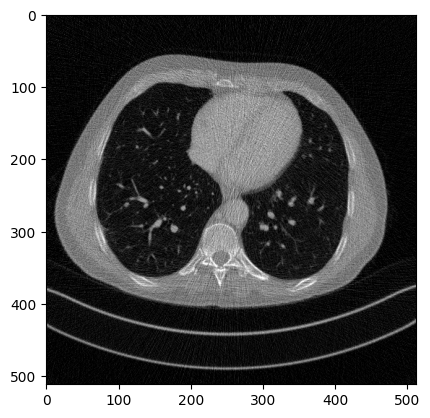

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load an example image
img = np.load('./AAPM_data/train/full_dose/1.npy')
print(type(img))
print(img.shape)
img = np.load('./AAPM_data/train/quarter_dose/1.npy')
print(type(img))
print(img.shape)

# Change linear attenuation coefficient into HU values
img = (img - 0.0192) / 0.0192 * 1000
# Clip the CT image with [-1000, 1000] HU
img = np.clip(img, -1000, 1000)

# Plot the example image
plt.imshow(img, cmap='gray')
plt.show()

### 2. Dataloader
Before the training of cycleGAN, data preprocessing (e.g. cliping, normalization) is required.


In [4]:
import random
from os import listdir
from os.path import join
from torch.utils.data import Dataset


# CT dataset
class CT_Dataset(Dataset):
  def __init__(self, path, transform):
    # Path of 'full_dose' and 'quarter_dose' folders
    self.path_full = join(path, 'full_dose')
    self.path_quarter = join(path, 'quarter_dose')
    self.transform = transform

    # File list of full dose data
    self.file_full = list()
    for file_name in sorted(listdir(self.path_full)):
      self.file_full.append(file_name)
    # random.seed(0)
    # random.shuffle(self.file_full)
    
    # File list of quarter dose data
    self.file_quarter = list()
    for file_name in sorted(listdir(self.path_quarter)):
      self.file_quarter.append(file_name)
  
  def __len__(self):
    return min(len(self.file_full), len(self.file_quarter))
  
  def __getitem__(self, idx):
    # Load full dose/quarter dose data
    x_F = np.load(join(self.path_full, self.file_full[idx]))
    x_Q = np.load(join(self.path_quarter, self.file_quarter[idx]))

    # Convert to HU scale
    x_F = (x_F - 0.0192) / 0.0192 * 1000
    x_Q = (x_Q - 0.0192) / 0.0192 * 1000

    # Normalize images
    x_F[x_F < -1000] = -1000
    x_Q[x_Q < -1000] = -1000

    x_F = x_F / 4000
    x_Q = x_Q / 4000

    # Apply transform
    x_F = self.transform(x_F)
    x_Q = self.transform(x_Q)

    file_name = self.file_quarter[idx]

    return x_F, x_Q, file_name

Because the size of CT images is too large, we have to crop the images into small size patches for training.
After training with patches, the whole size image will be used for the test.

In [5]:
import random
import torchvision
from torch.utils.data import DataLoader


# Transform for the random crop
class RandomCrop(object):
  def __init__(self, patch_size):
    self.patch_size = patch_size
  
  def __call__(self, img):
    # Randomly crop the image into a patch with the size [self.patch_size, self.patch_size]
    w, h = img.size(-1), img.size(-2)
    i = random.randint(0, h - self.patch_size)
    j = random.randint(0, w - self.patch_size)

    return img[:, i:i + self.patch_size, j:j + self.patch_size]


# Make dataloader for training/test
def make_dataloader(path, batch_size):
  # Path of 'train' and 'test' folders
  path_train = join(path, 'train')
  path_test = join(path, 'test')

  # Transform for training data: convert to tensor, random horizontal/verical flip, random crop
  # You can change transform if you want.
  train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomVerticalFlip(p=0.5),
    # RandomCrop(128)
  ])

  # Transform for test data: convert to tensor
  test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])

  # Generate CT dataset for training/test
  train_dataset = CT_Dataset(path_train, train_transform)
  test_dataset = CT_Dataset(path_test, test_transform)
  
  # Generate dataloader for training/test
  # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  # test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
  # thum_code
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
  test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

  return train_dataloader, test_dataloader



## II. Network: Generator / Discriminator
You have to implement basic blocks for generator/discriminator.
Refer to the 'ConvBlock', and make your own blocks for building generators/discriminators.

In [6]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler

# Example convolution block. You don't have to use this block.
# (Convolution, Batch normalization, ReLU) x 2
class ConvBlock(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels, affine=True, track_running_stats=True),
        nn.ReLU(),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
        nn.ReLU()
    )
  
  def forward(self, x):
    out = self.conv(x)
    return out
  
# thum_copy: from networks.py
# You can implement other building blocks for making generator and discriminator.
######################

class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

# methods
def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x):
            return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

def init_weights_(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights_(net, init_type, init_gain=init_gain)
    return net

def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)

######################

### 1. Generator(Supervised Learning)
Now, implement the generator and discriminator below.
You are free to choose the structure of the generator (e.g. U-Net, ResNet), but it should contain residual path.

In [7]:
# Generator
class Generator(nn.Module):
  def __init__(self, in_channels, out_channels, ngf):
    super(Generator, self).__init__()
    # in_channels: the number of channels of the input
    # out_channels: the number of channels of the output
    # ngf: the number of convolution filters of the first layer
    ######################
    # Your code
    self.netG = define_G(in_channels, out_channels, ngf, "unet_128")
    ######################
  
  def forward(self, x):
    ######################
    out = self.netG(x)
    ######################

    # Residual path: final output = output + input
    ######################
    x = x + out
    return x
    ######################

### 2. Discriminator
You have to construct PatchGAN structure for the discriminator as shown in PPT slide.

In [8]:
# Discriminator (PatchGAN)
class Discriminator(nn.Module):
  def __init__(self, in_channels, ndf):
    super(Discriminator, self).__init__()
    # in_channels: the number of channels of the input
    # ndf: the number of convolution filters of the first layer
    ######################
    self.netD = define_D(in_channels, ndf, "basic")
    ######################
  
  def forward(self, x):
    ######################
    return self.netD(x)
    ######################

## III. Other functions


In [9]:
from torch.nn import init


# initialize parameters of neural networks
def init_weights(net):
  def init_func(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
      init.normal_(m.weight.data, 0.0, 0.02)
      if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
      init.normal_(m.weight.data, 1.0, 0.02)
      init.constant_(m.bias.data, 0.0)
    
  print('Initialize network.')
  net.apply(init_func)


# Calculate average loss during one epoch
class Mean:
  def __init__(self):
    self.numel = 0
    self.mean = 0
  
  def __call__(self, val):
    self.mean = self.mean * (self.numel / (self.numel + 1)) + val / (self.numel + 1)
    self.numel += 1
  
  def result(self):
    return self.mean


# Show input and output images during training
def show_imgs(imgs, img_path, epoch):
  FQF = np.concatenate(imgs[:3], axis=2)
  img_array = np.squeeze(np.concatenate([FQF], axis=1))

  img_array = img_array * 4000
  img_array = np.clip(img_array, -1000, 1000)

  plt.imshow(img_array, cmap='gray')
  plt.imsave(os.path.join(img_path, str(epoch)+'.png'), img_array, cmap='gray')
  plt.show()


# Set 'requires_grad' of the networks
def set_requires_grad(nets, requires_grad=False):
  if not isinstance(nets, list):
    nets = [nets]
  for net in nets:
    if net is not None:
      for param in net.parameters():
        param.requires_grad = requires_grad

## IV. Training
Before training the network, some hyperparameters should be defined as follows.
You can change the value of hyperparameters if you want.

In [10]:
from os import makedirs
from os.path import isdir

# Hyperparameters
# You can change hyperparameters to find your best performance in your architecture.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 32
lambda_cycle = 10
lambda_iden = 5
beta1 = 0.5
beta2 = 0.999
num_epoch = 200
lr = 2e-5

# Path for saving the checkpoint
path_checkpoint = './checkpoint'
if not isdir(path_checkpoint):
  makedirs(path_checkpoint)

model_name = 'supervised_unet'

# Path for saving results
path_result = join(path_checkpoint, model_name)
path_image = join(path_checkpoint, model_name, "images")
if not isdir(path_result):
  makedirs(path_result)
  makedirs(path_image)

cuda


```model_name``` is the name of the model, and it will be used for saving the model.
If you want to continue the training from the last checkpoint, set ```model_name``` as the name of the saved model.
However, if you want to train a new model, you have to change ```model_name```.

Next, make dataloaders, networks, optimizers, and define loss functions.

In [11]:
import itertools

# path of dataset (change the path according to your setting)
path_data = './AAPM_data'

# Make dataloaders
train_dataloader, test_dataloader = make_dataloader(path_data, batch_size)

# Make generators (G_F2Q: full to quarter / G_Q2F: quarter to full)
####################
G_Q2F = Generator(1, 1, 16).to(device)
####################

print("G_F2Q, G_F2Q")
print(G_Q2F)

# Make optimizers
G_optim = torch.optim.Adam(itertools.chain( G_Q2F.parameters()), lr, betas=(beta1, beta2))

# Define loss functions
supv_loss = nn.L1Loss()

# Loss functions
loss_name = ['G_sup_loss']

initialize network with normal
G_F2Q, G_F2Q
Generator(
  (netG): UnetGenerator(
    (model): UnetSkipConnectionBlock(
      (model): Sequential(
        (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetSkipConnectionBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetSkipConnectionBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): UnetSkipConnectionBlock(
                  (model): Sequential(
                

In [12]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Functions for caculating PSNR, SSIM
def psnr(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  # print(val_max)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = peak_signal_noise_ratio(ref, A)
  return out

def ssim(A, ref):
  ref[ref < -1000] = -1000
  A[A < -1000] = -1000
  val_min = -1000
  val_max = np.amax(ref)
  ref = (ref - val_min) / (val_max - val_min)
  A = (A - val_min) / (val_max - val_min)
  out = structural_similarity(ref, A, data_range=2)
  return out

In [ ]:
from os.path import isfile
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

init_weights(G_Q2F)  
trained_epoch = 0
losses_list = {name: list() for name in loss_name}
np_losses_list = {name: list() for name in loss_name}
print('Start from random initialized model')

for epoch in tqdm(range(trained_epoch, num_epoch), desc='Epoch', total=num_epoch, initial=trained_epoch):
  print("Epoch: ", epoch+1)
  losses = {name: Mean() for name in loss_name}
  G_Q2F.train()


  for x_F, x_Q, _ in tqdm(train_dataloader, desc='Step'):
    x_F = x_F.to(device)
    x_Q = x_Q.to(device)

    # Set 'requires_grad' of the discriminators as 'False'
    ####################
    set_requires_grad(G_Q2F, requires_grad=True)    
    ####################

    x_QF = G_Q2F(x_Q)

    G_Q2F_loss = supv_loss(x_QF, x_F)

    G_optim.zero_grad()
    G_Q2F_loss.backward()
    G_optim.step()
  
    # Calculate the average loss during one epoch
    losses['G_sup_loss'](G_Q2F_loss.detach())
  
  for name in loss_name:
    losses_list[name].append(losses[name].result())
    torch.save(losses_list[name], join(path_result, name + '.npy'))
    print("name: ", name, losses[name].result().cpu().numpy())
    np_losses_list[name].append(losses[name].result().cpu().numpy())
    np.save(join(path_result, 'np_' + name + '.npy'), (np_losses_list[name]))


  # Save the trained model and list of losses
  torch.save({'epoch': epoch + 1,  'G_Q2F_state_dict': G_Q2F.state_dict(),}, join(path_checkpoint, model_name + '.pth'))


  # Plot input/output images every 10 epochs
  imgs = [x_F[0].detach().cpu().numpy(), x_Q[0].detach().cpu().numpy(), x_QF[0].detach().cpu().numpy()]
  show_imgs(imgs, path_image, epoch+1)

# log per 5epochs 
  if (epoch+1)%5 == 0:
    torch.save({'epoch': epoch + 1, 'G_Q2F_state_dict': G_Q2F.state_dict(),}, join(path_checkpoint, model_name + f'_{str(epoch+1)}.pth'))
    G_Q2F.eval()
    # make G_Q2F evaluation mode
    # Test and save
    with torch.no_grad():
      for _, x_Q, file_name in tqdm(test_dataloader):
        x_Q = x_Q.to(device)
        x_QF = G_Q2F(x_Q)[0].detach().cpu().numpy()
        x_QF = x_QF * 4000

        np.save(join(path_result, file_name[0]), x_QF)

    avg_original_psnr = []
    avg_original_ssim = []
    avg_model_out_psnr = []
    avg_model_out_ssim = []

    #save test dataset output.
    for i in range(1, 422):
        # How to use functions 'psnr' and 'ssim'
        path_quarter = os.path.join(path_data, f'test/quarter_dose/{i}.npy')
        path_full = os.path.join(path_data, f'test/full_dose/{i}.npy')
        path_output = os.path.join(path_result, f'{i}.npy')

        quarter = np.load(path_quarter)
        full = np.load(path_full)
        output = np.load(path_output)
        output = output.squeeze()

        quarter = (quarter - 0.0192) / 0.0192 * 1000
        full = (full - 0.0192) / 0.0192 * 1000

        # print(psnr(quarter, full), "|" , psnr(output,full))
        # print(ssim(quarter, full), "|" , ssim(output,full))

        avg_original_psnr.append(psnr(quarter, full))
        avg_original_ssim.append(ssim(quarter, full))
        avg_model_out_psnr.append(psnr(output, full))
        avg_model_out_ssim.append(ssim(output, full))

    print("average score of original psnr: ", sum(avg_original_psnr)/421.0)
    print("average score of model output psnr: ", sum(avg_model_out_psnr)/421.0)
    print("average score of original ssim: ", sum(avg_original_ssim)/421.0)
    print("average score of model output ssim: ", sum(avg_model_out_ssim)/421.0)

## V. Test
Last, you have to verify the performance of your network.

In [13]:
from tqdm.auto import tqdm

# average score of original psnr:  34.16952392478545
# average score of model output psnr:  34.16922081448021
# average score of original ssim:  0.8931997874844589
# average score of model output psnr:  0.8930020681009424

# Load the last checkpoint
checkpoint = torch.load(join(path_checkpoint, model_name + '.pth'))
G_Q2F.load_state_dict(checkpoint['G_Q2F_state_dict'])
G_Q2F.eval()

# Test and save
with torch.no_grad():
  for _, x_Q, file_name in tqdm(test_dataloader):
    x_Q = x_Q.to(device)
    x_QF = G_Q2F(x_Q)[0].detach().cpu().numpy()
    x_QF = x_QF * 4000

    np.save(join(path_result, file_name[0]), x_QF)

/home/work/miniconda3/envs/AI618/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 421/421 [00:17<00:00, 23.66it/s]


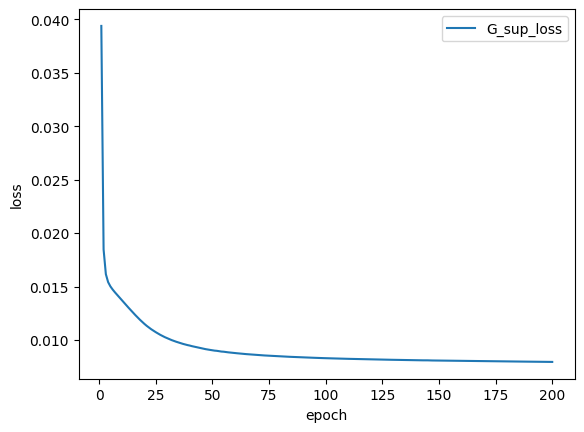

In [15]:
import matplotlib.pyplot as plt

# Plot loss graph (adversarial loss)
# x_axis = np.arange(1, num_epoch + 1)
#thum_code
x_axis = np.arange(1, 201)
plt.figure(1)
for name in ['G_sup_loss']:
  loss_arr = np.load(join(path_result, 'np_'+name + '.npy'))
  plt.plot(x_axis, loss_arr, label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig(join(path_result, 'loss_curve_1.png'))
plt.show()


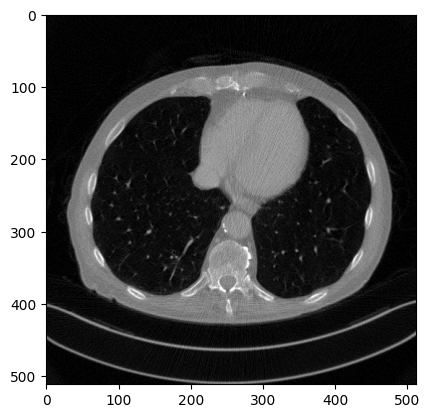

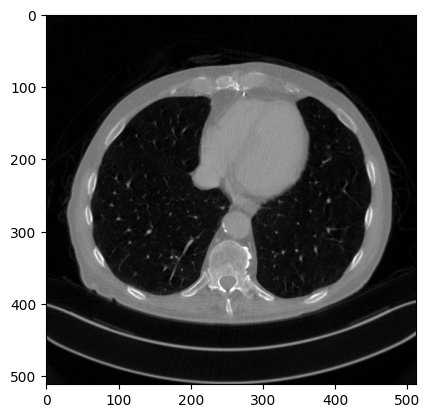

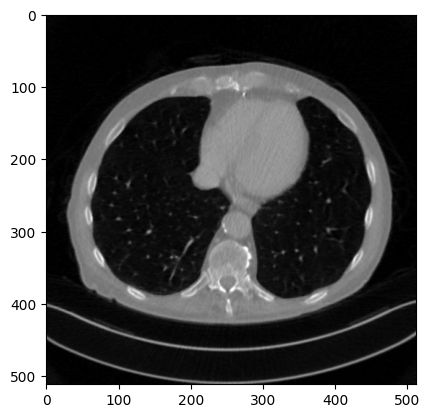

In [16]:
import matplotlib.pyplot as plt
from os.path import join as join

# Example of result
path_quarter = join(path_data, 'test/quarter_dose/4.npy')
path_full = join(path_data, 'test/full_dose/4.npy')
path_output = join(path_result, '4.npy')

quarter = np.load(path_quarter)
full = np.load(path_full)
output = np.load(path_output)

quarter = (quarter - 0.0192) / 0.0192 * 1000
full = (full - 0.0192) / 0.0192 * 1000

quarter = np.clip(quarter, -1000, 1000)
full = np.clip(full, -1000, 1000)
output = np.clip(output, -1000, 1000)

plt.imshow(quarter, cmap='gray')
plt.show()
plt.imshow(full, cmap='gray')
plt.show()
# print(full.shape)
# print(quarter.shape)
# print(output.shape)
plt.imshow(output.squeeze(), cmap='gray')
plt.show()

In [17]:
import os
import numpy as np

avg_original_psnr = []
avg_original_ssim = []
avg_model_out_psnr = []
avg_model_out_ssim = []

for i in range(1, 422):
    print(i)
    # How to use functions 'psnr' and 'ssim'
    path_quarter = os.path.join(path_data, f'test/quarter_dose/{i}.npy')
    path_full = os.path.join(path_data, f'test/full_dose/{i}.npy')
    path_output = os.path.join(path_result, f'{i}.npy')

    quarter = np.load(path_quarter)
    full = np.load(path_full)
    output = np.load(path_output)
    output = output.squeeze()

    quarter = (quarter - 0.0192) / 0.0192 * 1000
    full = (full - 0.0192) / 0.0192 * 1000


    print(psnr(quarter, full), "|" , psnr(output,full))
    print(ssim(quarter, full), "|" , ssim(output,full))

    avg_original_psnr.append(psnr(quarter, full))
    avg_original_ssim.append(ssim(quarter, full))
    avg_model_out_psnr.append(psnr(output, full))
    avg_model_out_ssim.append(ssim(output, full))

print("average score of original psnr: ", sum(avg_original_psnr)/421.0)
print("average score of model output psnr: ", sum(avg_model_out_psnr)/421.0)
print("average score of original ssim: ", sum(avg_original_ssim)/421.0)
print("average score of model output psnr: ", sum(avg_model_out_ssim)/421.0)

1
34.10847170590171 | 38.69955906610411
0.9095744032325875 | 0.9709757107032342
2
37.10867919688691 | 40.79539178299711
0.9510692812033413 | 0.982674271561108
3
34.983349020377524 | 38.5661460402654
0.9281931888106599 | 0.9740419477947421
4
33.872375863532 | 37.43665960906802
0.9134876284065694 | 0.9682826791311041
5
33.62430468426112 | 37.16552727026719
0.9096722679284595 | 0.9670279581221909
6
34.11847560867507 | 37.59120033466308
0.9178588289641968 | 0.9698633976537582
7
34.492749204621695 | 37.774185409784245
0.9237664603908027 | 0.9712345954483835
8
34.95614614281867 | 38.20410878783726
0.9299532748619929 | 0.9739226627415782
9
35.26445886718562 | 38.51647259195522
0.9339844923868078 | 0.9753130898860843
10
35.461267191884474 | 38.68933148432836
0.9368709322258861 | 0.9760589013542974
11
35.414655461463084 | 38.636186891112246
0.9358322089687114 | 0.9758014745432848
12
34.92819842842259 | 38.12409499294239
0.9305883970876175 | 0.9733171870823412
13
35.11589271557239 | 38.337305901